## Bispectrum Interpolation Routines
This notebook contains example code for reading in the one-loop bispectrum templates (in HDF5 form, as computed by the Output.wls script), and producing full estimates of the one-loop bispectrum for any combination of parameters. The precomputed templates are combined together using linear interpolation, giving a function that can compute the bispectrum for arbitrary $k_i$ and $\mu_i$ (subject to the triangle conditions). 

In [1]:
%pylab inline
import h5py
from scipy.interpolate import RegularGridInterpolator
from scipy.special import p_roots
import time

# File string
string = 'ptc'
# Input directory
indir = '/Users/ophilcox/Desktop/OneLoopBispectrum/output'

Populating the interactive namespace from numpy and matplotlib


### 1) Load the bispectrum templates

In [2]:
## Load hdf5 file
print("Loading full templates")
infile = h5py.File(indir+'/'+string+'_full.h5','r') 

kk = np.asarray(infile['k'])
xx = np.asarray(infile['x'])
yy = np.asarray(infile['y'])

b211 = np.asarray(infile['211'])
b222 = np.asarray(infile['222'])
b321I = np.asarray(infile['321I'])
b321II = np.asarray(infile['321II'])
b411 = np.asarray(infile['411'])

## Define mesh of grid points
kt = np.meshgrid(kk,xx)[0].T.ravel()
xt = np.meshgrid(kk,xx)[1].T.ravel()
yt = np.meshgrid(kk,yy)[1].T.ravel()
kxy = np.vstack([kt,xt,yt]).T
lkxy = kxy.copy()
lkxy[:,0] = np.log(kxy[:,0])
lkxy[:,1:] = np.sqrt(kxy[:,1:])

Loading full templates


In [3]:
## Load hdf5 file
print("Loading flat templates")

infileF = h5py.File(indir+'/'+string+'_flat.h5','r') 

kkF = np.asarray(infileF['k'])
xxF = np.asarray(infileF['x'])
yyF = np.asarray(infileF['y'])
xxF[0] = 0. # for array regularity

# Create full arrays with flattened spectra (for interpolation)
b211F = np.zeros((47,len(xxF),len(kkF),len(b211[0,0,0])))
b222F = np.zeros((47,len(xxF),len(kkF),len(b222[0,0,0])))
b321IF = np.zeros((47,len(xxF),len(kkF),len(b321I[0,0,0])))
b321IIF = np.zeros((47,len(xxF),len(kkF),len(b321II[0,0,0])))
b411F = np.zeros((47,len(xxF),len(kkF),len(b411[0,0,0])))
newInd = -1
for i in range(13):
    for j in range(11):
        if (i+j)%2==1: continue
        if (i+j)>12: continue
        newInd +=1
        if j!=0: continue
        b211F[newInd] = infileF['211'][i//2]
        b222F[newInd] = infileF['222'][i//2]
        b321IF[newInd] = infileF['321I'][i//2]
        b321IIF[newInd] = infileF['321II'][i//2]
        b411F[newInd] = infileF['411'][i//2]

## Define mesh of grid points
ktF = np.meshgrid(kkF,xxF)[0].T.ravel()
xtF = np.meshgrid(kkF,xxF)[1].T.ravel()
ytF = np.meshgrid(kkF,yyF)[1].T.ravel()
kxyF = np.vstack([ktF,xtF,ytF]).T
lkxyF = kxyF.copy()
lkxyF[:,0] = np.log(kxyF[:,0])
lkxyF[:,1:] = np.sqrt(kxyF[:,1:])

Loading flat templates


In [4]:
print("Combine interpolation tables")
## Combine two interpolation tables together
b211t = np.concatenate([b211,b211F],axis=1)
b222t = np.concatenate([b222,b222F],axis=1)
b321It = np.concatenate([b321I,b321IF],axis=1)
b321IIt = np.concatenate([b321II,b321IIF],axis=1)
b411t = np.concatenate([b411,b411F],axis=1)

xxt = np.concatenate([xx,xxF])
yyt = np.concatenate([yy,yyF])
kkt = kk.copy()
ktt = np.meshgrid(kkt,xxt)[0].T.ravel()
xtt = np.meshgrid(kkt,xxt)[1].T.ravel()
ytt = np.meshgrid(kkt,yyt)[1].T.ravel()
kxyt = np.vstack([ktt,xtt,ytt]).T

# Transform to log(k), sqrt(x), sqrt(y) for regular interpolation
lkxyt = kxyt.copy()
lkxyt[:,0] = np.log(kxyt[:,0])
lkxyt[:,1:] = np.sqrt(kxyt[:,1:])

Combine interpolation tables


### 2) Create Interpolators

- We use linear interpolation on a regular 3D grid of log(k), sqrt(x), sqrt(y)
- Note that this includes corners of the 3D grid we don't care about, i.e. those far from obeying the triangle conditions.
- NB: The interpolator below with ```method='nearest'``` is faster still, but has the caveat that it only does nearest-neighbor interpolation. ```method='linear'``` is usually a safer option.

In [5]:
## Define regular grid of points
kAll = np.unique(kkt)
xAll = np.unique(xxt)
yAll = np.unique(yyt)

def Interpolate3Dreg(bkTable,method='linear'):
    """Reconstruct full 3D interpolation table for all biases and angles simultaneously. 
    If this is used for vector k1,k2,k3, they should be *ordered* such that k1 > k2 > k3. This will *not* be checked at runtime.
    This function will return NaNs if the inputs do not obey the triangle conditions.
    """

    # Construct interpolation table
    flatTab = np.asarray([[np.ravel(bkTable[i,:,:,j].T) for j in range(len(bkTable[0,0,0]))] for i in range(len(bkTable))])
    vals = np.zeros((len(kAll),len(xAll),len(yAll),len(flatTab),len(flatTab[0])))
    
    for i in range(len(flatTab[0,0])):
        ind1 = np.where(kAll==kxyt[i,0])
        ind2 = np.where(xAll==kxyt[i,1])
        ind3 = np.where(yAll==kxyt[i,2])
        vals[ind1,ind2,ind3] = flatTab[:,:,i]

    # Define regular interpolator
    rg = RegularGridInterpolator((np.log(kAll),np.sqrt(xAll),np.sqrt(yAll)),vals,method=method,bounds_error=False)

    # Define output function
    def BkInt(k1,k2,k3):
        if type(k1)==np.ndarray:
            # Note no bounds-checking here!
            k = k1
            x = (k3/k1)**2;
            y = (k2/k1)**2;
            return rg((np.log(k), np.sqrt(x), np.sqrt(y)))
        else:
            k123 = np.sort([k1,k2,k3])
            k = k123[2]
            x = (k123[0]/k)**2;
            y = (k123[1]/k)**2;
            return rg((np.log(k), np.sqrt(x), np.sqrt(y)))
    return BkInt

## Define interpolators
# These return a grid of all biases + mu coefficients simultaneously
b211int = Interpolate3Dreg(b211t)
b222int = Interpolate3Dreg(b222t)
b321Iint = Interpolate3Dreg(b321It)
b321IIint = Interpolate3Dreg(b321IIt)
b411int = Interpolate3Dreg(b411t)

The output interpolators return arrays of bispectrum templates containing all bias parameters and all 47 choices of $\mu,\chi$ components. To use them, we must specify the values of $\{k_1,k_2,k_3\}$ (as scalars or arrays). For example:

In [6]:
k1 = 0.4
k2 = 0.3
k3 = 0.2
b222_templates = b222int(k1,k2,k3)
print("Dimensions: ",b222_templates.shape)

Dimensions:  (47, 50)


### 3) Define Bias Parameters
- Here, we use the coevolution predictions for bias parameters. 
- These are not quite correct in practice, but are useful for the sake of illustration.
- We form the bias parameters into arrays which can be dotted with the bispectrum outputs

In [7]:
# Coevolution biases with only b1L and b2L non-zero 
b1L = 1; # Lagrangian b1
b2L = 0.3; # Lagrangian b2
f = 0.7; # Growth factor

# Coevolution prediction
b1 = b1L + 1;
b2 = b2L;
b3 = -3*b2;
g2 =  -(2/7)*b1L;
g3 = -(1/9)*b1L - g2;
g21 = 2/21*b1L + 6/7*g2;
g2x = -(2/7)*b2;
g22 = -(6/539)*b1L - 9/49*g2;
g21x = 2/21*b2 + 2/7*g2x;
g31 = -(4/11)*b1L - 6*g2;
g211 = 5/77*b1L + 15/14*g2 + g21 - 9/7*g3;

# Define bias lists
biasListB211 = [b1**3,b1**2*b2,b1**2*f,b1**3*f,b1*b2*f,b1*f**2,b1**2*f**2,b2*f**2,f**3,b1*f**3,f**4,b1**2*g2,b1*f*g2,f**2*g2]
biasListB222 = [b1**3,b1**2*b2,b1*b2**2,b2**3,b1**2*f,b1**3*f,b1*b2*f,b1**2*b2*f,b2**2*f,b1*b2**2*f,b1*f**2,b1**2*f**2,b1**3*f**2,b2*f**2,
                b1*b2*f**2,b1**2*b2*f**2,b2**2*f**2,f**3,b1*f**3,b1**2*f**3,b1**3*f**3,b2*f**3,b1*b2*f**3,f**4,b1*f**4,b1**2*f**4,b2*f**4,f**5,
                b1*f**5,f**6,b1**2*g2,b1*b2*g2,b2**2*g2,b1*f*g2,b1**2*f*g2,b2*f*g2,b1*b2*f*g2,f**2*g2,b1*f**2*g2,b1**2*f**2*g2,b2*f**2*g2,
                f**3*g2,b1*f**3*g2,f**4*g2,b1*g2**2,b2*g2**2,f*g2**2,b1*f*g2**2,f**2*g2**2,g2**3]
biasListB321I = [b1**3,b1**2*b2,b1*b2**2,b1**2*b3,b1*b2*b3,b1**2*f,b1**3*f,b1*b2*f,b1**2*b2*f,b2**2*f,b1*b2**2*f,b1*b3*f,b1**2*b3*f,b2*b3*f,
                 b1*f**2,b1**2*f**2,b1**3*f**2,b2*f**2,b1*b2*f**2,b1**2*b2*f**2,b2**2*f**2,b3*f**2,b1*b3*f**2,f**3,b1*f**3,b1**2*f**3,b1**3*f**3,
                 b2*f**3,b1*b2*f**3,b3*f**3,f**4,b1*f**4,b1**2*f**4,b2*f**4,f**5,b1*f**5,f**6,b1**2*g2,b1*b2*g2,b1*b3*g2,b1*f*g2,b1**2*f*g2,
                 b2*f*g2,b1*b2*f*g2,b3*f*g2,f**2*g2,b1*f**2*g2,b1**2*f**2*g2,b2*f**2*g2,f**3*g2,b1*f**3*g2,f**4*g2,b1*g2**2,f*g2**2,b1*f*g2**2,
                 f**2*g2**2,b1**2*g21,b1*b2*g21,b1*f*g21,b1**2*f*g21,b2*f*g21,f**2*g21,b1*f**2*g21,f**3*g21,b1*g2*g21,f*g2*g21,b1**2*g2x,
                 b1*b2*g2x,b1*f*g2x,b1**2*f*g2x,b2*f*g2x,f**2*g2x,b1*f**2*g2x,f**3*g2x,b1*g2*g2x,f*g2*g2x,b1**2*g3,b1*b2*g3,b1*f*g3,b1**2*f*g3,
                 b2*f*g3,f**2*g3,b1*f**2*g3,f**3*g3,b1*g2*g3,f*g2*g3]
biasListB321II = [b1**3,b1**2*b2,b1**2*f,b1**3*f,b1*b2*f,b1*f**2,b1**2*f**2,b1**3*f**2,b2*f**2,b1*b2*f**2,b1**2*b2*f**2,f**3,b1*f**3,
                  b1**2*f**3,b1**3*f**3,b2*f**3,b1*b2*f**3,f**4,b1*f**4,b1**2*f**4,b2*f**4,f**5,b1*f**5,f**6,b1**2*g2,b1*b2*g2,b1*f*g2,b1**2*f*g2,
                  b2*f*g2,f**2*g2,b1*f**2*g2,b1**2*f**2*g2,f**3*g2,b1*f**3*g2,f**4*g2,b1*g2**2,f*g2**2,b1**2*g21,b1*b2*g21,b1*f*g21,b1**2*f*g21,
                  b2*f*g21,f**2*g21,b1*f**2*g21,f**3*g21,b1*g2*g21,f*g2*g21]
biasListB411 = [b1**3,b1**2*b2,b1**2*b3,b1**2*f,b1**3*f,b1*b2*f,b1**2*b2*f,b1*b3*f,b1**2*b3*f,b1*f**2,b1**2*f**2,b1**3*f**2,b2*f**2,
                b1*b2*f**2,b1**2*b2*f**2,b3*f**2,b1*b3*f**2,f**3,b1*f**3,b1**2*f**3,b1**3*f**3,b2*f**3,b1*b2*f**3,b3*f**3,f**4,b1*f**4,
                b1**2*f**4,b2*f**4,f**5,b1*f**5,f**6,b1**2*g2,b1*f*g2,b1**2*f*g2,f**2*g2,b1*f**2*g2,b1**2*f**2*g2,f**3*g2,b1*f**3*g2,f**4*g2,
                b1**2*g21,b1*f*g21,b1**2*f*g21,f**2*g21,b1*f**2*g21,f**3*g21,b1**2*g211,b1*f*g211,f**2*g211,b1**2*g21x,b1*f*g21x,f**2*g21x,
                b1**2*g22,b1*f*g22,f**2*g22,b1**2*g2x,b1*f*g2x,b1**2*f*g2x,f**2*g2x,b1*f**2*g2x,f**3*g2x,b1**2*g3,b1*f*g3,b1**2*f*g3,f**2*g3,
                b1*f**2*g3,f**3*g3,b1**2*g31,b1*f*g31,f**2*g31]
print("Number of B211 bias coefficients: ",len(biasListB211))
print("Number of B222 bias coefficients: ",len(biasListB222))
print("Number of B321-I bias coefficients: ",len(biasListB321I))
print("Number of B321-II bias coefficients: ",len(biasListB321II))
print("Number of B411 bias coefficients: ",len(biasListB411))

Number of B211 bias coefficients:  14
Number of B222 bias coefficients:  50
Number of B321-I bias coefficients:  86
Number of B321-II bias coefficients:  47
Number of B411 bias coefficients:  70


### 4) Output Interpolated Bispectra

To produce the bispectrum for a specific choice of biases and angles, we call the above interpolators and dot the results with an array of angular coefficients and the above bias vectors. Here, we'll produce results for fixed $k_2/k_1$ and $k_3/k_1$, but for a range of values of $k_1$.

In [8]:
# Define some coordinates
k_arr = np.geomspace(0.005,0.5,1000)
x1 = 0.3;
y1 = 0.6;
mu = 0.3;
cosphi = 0.9;

# Chek triangle conditions
assert np.sqrt(x1)+np.sqrt(y1)>1, "Triangle conditions are not satisfied!"

def muVecFunc(mu1,cosphi):
    """Create array of (mu, chi) angular coordinates, where chi = Sqrt[1-mu^2]Cos[phi]"""
    out = []
    for i in range(13):
        for j in range(11):
            if i+j>12: continue
            if (i+j)%2==1: continue
            out.append(mu1**i*(np.sqrt(1.-mu1**2.)*cosphi)**j)
    return np.asarray(out)

# Compute the array of mu1,mu2 powers
muVec = muVecFunc(mu,np.sqrt(1.-mu**2.)*cosphi)

# Compute the bispectra at the given coordinates for all biases and angles simultaneously
# Note that we dot this with the angular components and the list of bias parameters
# For Python2 users, the @ operator should be replaced by np.matmul
init = time.time()
b211_arr = muVec@b211int(k_arr,sqrt(y1)*k_arr,sqrt(x1)*k_arr)@biasListB211
b222_arr = muVec@b222int(k_arr,sqrt(y1)*k_arr,sqrt(x1)*k_arr)@biasListB222
b321I_arr = muVec@b321Iint(k_arr,sqrt(y1)*k_arr,sqrt(x1)*k_arr)@biasListB321I
b321II_arr = muVec@b321IIint(k_arr,sqrt(y1)*k_arr,sqrt(x1)*k_arr)@biasListB321II
b411_arr = muVec@b411int(k_arr,sqrt(y1)*k_arr,sqrt(x1)*k_arr)@biasListB411
print("Interpolation time: %.2fs"%(time.time()-init))

Interpolation time: 0.83s


Let's plot the resulting spectra:

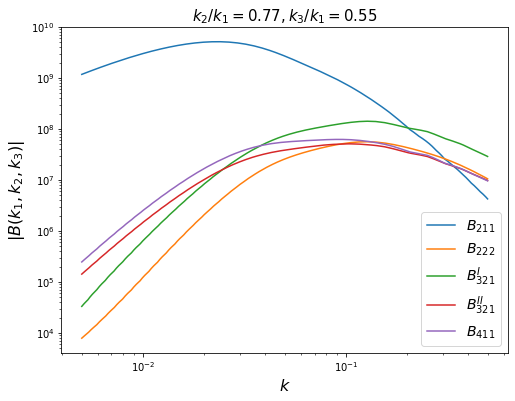

In [9]:
### Plot the output
plt.figure(figsize=(8,6))
plt.loglog(k_arr,np.abs(b211_arr),label=r"$B_{211}$")
plt.loglog(k_arr,np.abs(b222_arr),label=r"$B_{222}$")
plt.loglog(k_arr,np.abs(b321I_arr),label=r"$B_{321}^I$")
plt.loglog(k_arr,np.abs(b321II_arr),label=r"$B_{321}^{II}$")
plt.loglog(k_arr,np.abs(b411_arr),label=r"$B_{411}$")
plt.legend(fontsize=14);
plt.xlabel(r'$k$',fontsize=16)
plt.ylabel(r'$|B(k_1,k_2,k_3)|$',fontsize=16);
plt.title(r'$k_2/k_1 = %.2f, k_3/k_1 = %.2f$'%(np.sqrt(y1),np.sqrt(x1)),fontsize=15);

### 5) (Optional) Integrate the bispectrum over finite bins
- Here, we perform bin integration over both the radial and angular components of the bispectrum, to obtain the bin-averaged bispectrum monopole. This includes Alcock-Paczynski distortions to the spectra, and, for the one-loop components, is the full form used in the recent one-loop bispectrum analyses (with an externally computed tree-level piece, including additional IR resummation effects).

First, we define some preliminary functions.

In [10]:
# Define Gauss-Legendre integration points
n_gauss = 3
n_gauss2 = 8
[gauss_mu,gauss_w], [gauss_mu2,gauss_w2] = p_roots(n_gauss), p_roots(n_gauss2)
k1,k2,k3,mu1,phi = np.meshgrid(gauss_mu,gauss_mu,gauss_mu,gauss_mu2,gauss_mu2, sparse=True, indexing='ij')

# Bin width
dk = 0.01

def reorder_kmu(k1AP,k2AP,k3AP,mu1AP,mu2AP,mu3AP):
    """Switch k and mu vectors into the ordering with k1 >= k2 >= k3, as needed for the interpolators."""
    
    # Order k vectors
    args = np.argsort([k1AP,k2AP,k3AP],axis=0)

    # Define ordered set
    k1APord = np.zeros_like(k1AP)
    k2APord = np.zeros_like(k2AP)
    k3APord = np.zeros_like(k3AP)
    mu1APord = np.zeros_like(mu1AP)
    mu2APord = np.zeros_like(mu2AP)
    mu3APord = np.zeros_like(mu3AP)

    # biggest k
    k1APord[args[2]==0] = k1AP[args[2]==0]
    k1APord[args[2]==1] = k2AP[args[2]==1]
    k1APord[args[2]==2] = k3AP[args[2]==2]
    mu1APord[args[2]==0] = mu1AP[args[2]==0]
    mu1APord[args[2]==1] = mu2AP[args[2]==1]
    mu1APord[args[2]==2] = mu3AP[args[2]==2]

    # middle k
    k2APord[args[1]==0] = k1AP[args[1]==0]
    k2APord[args[1]==1] = k2AP[args[1]==1]
    k2APord[args[1]==2] = k3AP[args[1]==2]
    mu2APord[args[1]==0] = mu1AP[args[1]==0]
    mu2APord[args[1]==1] = mu2AP[args[1]==1]
    mu2APord[args[1]==2] = mu3AP[args[1]==2]

    # smallest k
    k3APord[args[0]==0] = k1AP[args[0]==0]
    k3APord[args[0]==1] = k2AP[args[0]==1]
    k3APord[args[0]==2] = k3AP[args[0]==2]
    mu3APord[args[0]==0] = mu1AP[args[0]==0]
    mu3APord[args[0]==1] = mu2AP[args[0]==1]
    mu3APord[args[0]==2] = mu3AP[args[0]==2]
    
    return k1APord, k2APord, k3APord, mu1APord, mu2APord, mu3APord

def bin_integrate(B_matrix):
    """Integrate a function over k and mu bins via Gauss-Legendre quadrature"""
    Btmp = np.moveaxis(B_matrix,-1,0)
    return np.matmul(np.matmul(np.matmul(np.matmul(np.matmul(Btmp,gauss_w2),gauss_w2),gauss_w),gauss_w),gauss_w)/4.

The following function computes the bin-averaged bispectrum:

In [11]:
def binned_bispectrum(kc1,kc2,kc3,apar=1,aperp=1,s8=1):
    """This computes the bin-averaged bispectrum, given bin-centers at {kc1, kc2, kc3} and Alcock-Paczynski parameters {apar, aperp}.
    The s8 parameter allows for rescaling of sigma8, with s8 = (sigma8_true / sigma8_fid).
    
    The outputs contain the bin-averaged spectra for all possible biases."""

    # Define bin parameters
    ddk1 = dk/2.
    ddk2 = dk/2.
    ddk3 = dk/2.
    kk1 = (kc1+k1*ddk1)
    kk2 = (kc2+k2*ddk2)
    kk3 = (kc3+k3*ddk3)

    # Define mu1, mu2, mu3 angles
    xxfunc = (kk3**2.-kk1**2.-kk2**2.)/(2.*kk1*kk2)
    yyfunc = np.sqrt(np.abs(1.-xxfunc**2.))
    mu2 = xxfunc*mu1 - np.sqrt(1.-mu1**2.)*yyfunc*np.cos(phi*2.*np.pi)
    mu3 = -(kk2/kk3)*mu2-(kk1/kk3)*mu1

    # Coordinate distortion on mu
    nnu = lambda mu: mu/apar/(np.sqrt(np.abs(mu**2./apar**2. + (1-mu**2.)/aperp**2.)))
    nnu1, nnu2, nnu3 = nnu(mu1), nnu(mu2), nnu(mu3)

    # Coordinate distortion on length
    qq = lambda mu: np.sqrt(np.abs(mu**2/apar**2 + (1.-mu**2)/aperp**2))
    qq1, qq2, qq3 = qq(mu1), qq(mu2), qq(mu3)

    ## Define new angles
    shape = np.ones((n_gauss,n_gauss,n_gauss,n_gauss2,n_gauss2))
    k1AP = (kk1*qq1)*shape
    k2AP = (kk2*qq2)*shape
    k3AP = (kk3*qq3)*shape
    mu1AP = nnu1*shape
    mu2AP = nnu2*shape
    mu3AP = nnu3*shape
    
    # Reorder vectors to ensure k1 >= k2 >= k3
    k1APord, k2APord, k3APord, mu1APord, mu2APord, mu3APord = reorder_kmu(k1AP,k2AP,k3AP,mu1AP,mu2AP,mu3AP)
    
    # Define cosphi angle
    cc = (k3APord**2.-k1APord**2.-k2APord**2.)/(2.*k1APord*k2APord)
    ss = np.sqrt(np.abs(1.-cc**2.)) # adding abs to avoid boundary errors!
    chiAPord = (mu1APord*cc-mu2APord)/(ss+1e-12)
    
    # Define mu array
    muVec = np.moveaxis(muVecFunc(mu1APord,chiAPord),0,-1)
    # Define volume element
    volEl = (kk1*kk2*kk3*ddk1*ddk2*ddk3*shape)[:,:,:,:,:,None]
    
    # Perform the (vectorized) interpolation, including all angular components and biases
    b211matrix = np.sum(muVec[:,:,:,:,:,:,None]*b211int(k1APord,k2APord,k3APord),axis=5)
    b222matrix = np.sum(muVec[:,:,:,:,:,:,None]*b222int(k1APord,k2APord,k3APord),axis=5)
    b321Imatrix = np.sum(muVec[:,:,:,:,:,:,None]*b321Iint(k1APord,k2APord,k3APord),axis=5)
    b321IImatrix = np.sum(muVec[:,:,:,:,:,:,None]*b321IIint(k1APord,k2APord,k3APord),axis=5)
    b411matrix = np.sum(muVec[:,:,:,:,:,:,None]*b411int(k1APord,k2APord,k3APord),axis=5)
    
    # Impose triangle conditions
    triangle_conditions = ((np.abs(k1APord-k2APord)<=k3APord)&(k3APord<=(k1APord+k2APord)))[:,:,:,:,:,None]
    
    b211matrix = np.where(triangle_conditions,b211matrix,0.)
    b222matrix = np.where(triangle_conditions,b222matrix,0.)
    b321Imatrix = np.where(triangle_conditions,b321Imatrix,0.)
    b321IImatrix = np.where(triangle_conditions,b321IImatrix,0.)
    b411matrix = np.where(triangle_conditions,b411matrix,0.)

    # Define bin volume (using only good triangles)
    Nk123 = bin_integrate(volEl*triangle_conditions)
    
    # Perform bin integration
    b211integ = s8**4*bin_integrate(b211matrix*volEl)/Nk123/apar**2./aperp**4
    b222integ = s8**6*bin_integrate(b222matrix*volEl)/Nk123/apar**2./aperp**4
    b321Iinteg = s8**6*bin_integrate(b321Imatrix*volEl)/Nk123/apar**2./aperp**4
    b321IIinteg = s8**6*bin_integrate(b321IImatrix*volEl)/Nk123/apar**2./aperp**4
    b411integ = s8**6*bin_integrate(b411matrix*volEl)/Nk123/apar**2./aperp**4

    return b211integ, b222integ, b321Iinteg, b321IIinteg, b411integ

The output is a set of bin-integrated bispectra for each template configuration ($B_{211}$, $B_{222}$, etc.) and bias. Let's check:

In [12]:
init = time.time()
bk_output = binned_bispectrum(0.1,0.2,0.2)
print("Bin-integration took %.3f s"%(time.time()-init))
print("B_211 Dimensions: ",bk_output[0].shape)
print("B_222 Dimensions: ",bk_output[1].shape)
print("B_321-I Dimensions: ",bk_output[2].shape)
print("B_321-II Dimensions: ",bk_output[3].shape)
print("B_411 Dimensions: ",bk_output[4].shape)

Bin-integration took 1.399 s
B_211 Dimensions:  (14,)
B_222 Dimensions:  (50,)
B_321-I Dimensions:  (86,)
B_321-II Dimensions:  (47,)
B_411 Dimensions:  (70,)


We'll compute the bispectrum for all allowed triangles within a certain set of scales. This would be the input for a likelihood evaluation. Note that if Alcock-Paczynski parameters are not varied, the bin-integration only needs to be performed once, since we have not yet fixed the values of the bias parameters.

In [13]:
# Binning parameters
kmax = 0.105
kmin = 0.015
dk=0.01

# 1D array of k values
k = np.arange(kmin,kmax+dk,dk)
k_size = len(k)

# Compute array of triangle values
k123s = []
for i1 in range(k_size):
    for i2 in range(i1,k_size):
        for i3 in range(i2,k_size):
            # Check centers satisfy triangle-conditions!
            if k[i3]<=k[i1]+k[i2] and k[i3]>=np.abs(k[i1]-k[i2]):
                k123s.append([k[i1],k[i2],k[i3]])
                
n123 = len(k123s)
print("Using %d triangles with k_min = %.3f, k_max = %.3f and delta_k = %.3f"%(n123,kmin,kmax,dk))

Using 150 triangles with k_min = 0.015, k_max = 0.105 and delta_k = 0.010


In [ ]:
init = time.time()

# Create output arrays
Bint211 = np.zeros((n123,len(biasListB211)))
Bint222 = np.zeros((n123,len(biasListB222)))
Bint321I = np.zeros((n123,len(biasListB321I)))
Bint321II = np.zeros((n123,len(biasListB321II)))
Bint411 = np.zeros((n123,len(biasListB411)))

# Define AP parameters and s8
apar = 0.97
aperp = 1.04
s8 = 1.03
print("alpha-parallel: %.3f"%apar)
print("alpha-perp: %.3f"%aperp)
print("sigma8 ratio: %.3f"%s8)

for j in range(n123):
    
    # Define bin centers
    kc1,kc2,kc3 = k123s[j]
    print("k-bin %d of %d: %.3f %.3f %.3f"%(j+1,n123,kc1,kc2,kc3))
    
    # Compute the binned bispectrum
    bk_output = binned_bispectrum(kc1=kc1,kc2=kc2,kc3=kc3,apar=apar,aperp=aperp)
    
    # Save output
    Bint211[j] = bk_output[0]
    Bint222[j] = bk_output[1]
    Bint321I[j] = bk_output[2]
    Bint321II[j] = bk_output[3]
    Bint411[j] = bk_output[4]
    
print("\nRuntime = %.3f s for %d triangles"%(time.time()-init,n123))

alpha-parallel: 0.970
alpha-perp: 1.040
sigma8 ratio: 1.030
k-bin 1 of 150: 0.015 0.015 0.015
k-bin 2 of 150: 0.015 0.015 0.025


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


k-bin 3 of 150: 0.015 0.025 0.025
k-bin 4 of 150: 0.015 0.025 0.035
k-bin 5 of 150: 0.015 0.035 0.035
k-bin 6 of 150: 0.015 0.035 0.045
k-bin 7 of 150: 0.015 0.045 0.045
k-bin 8 of 150: 0.015 0.045 0.055
k-bin 9 of 150: 0.015 0.055 0.055
k-bin 10 of 150: 0.015 0.055 0.065
k-bin 11 of 150: 0.015 0.065 0.065
k-bin 12 of 150: 0.015 0.065 0.075
k-bin 13 of 150: 0.015 0.075 0.075
k-bin 14 of 150: 0.015 0.075 0.085
k-bin 15 of 150: 0.015 0.085 0.085
k-bin 16 of 150: 0.015 0.085 0.095
k-bin 17 of 150: 0.015 0.095 0.095
k-bin 18 of 150: 0.015 0.095 0.105
k-bin 19 of 150: 0.015 0.105 0.105
k-bin 20 of 150: 0.025 0.025 0.025
k-bin 21 of 150: 0.025 0.025 0.035
k-bin 22 of 150: 0.025 0.025 0.045
k-bin 23 of 150: 0.025 0.035 0.035
k-bin 24 of 150: 0.025 0.035 0.045
k-bin 25 of 150: 0.025 0.035 0.055
k-bin 26 of 150: 0.025 0.045 0.045
k-bin 27 of 150: 0.025 0.045 0.055
k-bin 28 of 150: 0.025 0.045 0.065
k-bin 29 of 150: 0.025 0.055 0.055
k-bin 30 of 150: 0.025 0.055 0.065
k-bin 31 of 150: 0.025 0.05

Let's plot the output, specializing to coevolution biases for illustration.

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Bin-averaged bispectra",fontsize=16)
plt.plot(np.abs(Bint211@biasListB211+Bint222@biasListB222+Bint321I@biasListB321I+Bint321II@biasListB321II+Bint411@biasListB411),label='Total',c='k')
plt.plot(np.abs(Bint211@biasListB211),label=r'$B_{211}$',c='r')
plt.plot(np.abs(Bint222@biasListB222),label=r'$B_{222}$',c='b')
plt.plot(np.abs(Bint321I@biasListB321I),label=r'$B_{321}^I$',c='g')
plt.plot(np.abs(Bint321II@biasListB321II),label=r'$B_{321}^{II}$',c='y')
plt.plot(np.abs(Bint411@biasListB411),label=r'$B_{411}$',c='purple')
plt.yscale('log')
plt.legend(fontsize=14,bbox_to_anchor=(1.,0.7))
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$|B_{xyz}(k_1,k_2,k_3)|$',fontsize=17);
plt.xlim([0,n123-1])